In [1]:
# If not already installed, do: pip install pandas fastparquet
import pandas as pd

URL_DATA = 'https://storage.data.gov.my/transportation/ktmb/ets_2025.parquet'

df = pd.read_parquet(URL_DATA)
if 'date' in df.columns: df['date'] = pd.to_datetime(df['date'])

print(df)

             date   time         origin    destination  ridership
0      2025-01-01  00:00     Batu Gajah     Alor Setar          1
1      2025-01-01  00:00     Batu Gajah           Arau          1
2      2025-01-01  00:00     Batu Gajah   Padang Besar          1
3      2025-01-01  00:00         Kampar   Padang Besar          2
4      2025-01-01  00:00  Tanjong Malim     Alor Setar          1
...           ...    ...            ...            ...        ...
179909 2025-05-15  23:00   Sungai Buloh     Alor Setar          4
179910 2025-05-15  23:00   Sungai Buloh           Arau          3
179911 2025-05-15  23:00   Sungai Buloh   Padang Besar         35
179912 2025-05-15  23:00   Sungai Buloh  Sungai Petani          1
179913 2025-05-15  23:00  Tanjong Malim           Ipoh          2

[179914 rows x 5 columns]


In [2]:
df_daily = df.groupby('date')['ridership'].sum().reset_index()

In [3]:
df_daily.set_index('date',inplace=True)

In [4]:
print(df_daily)

            ridership
date                 
2025-01-01      11434
2025-01-02      11010
2025-01-03      11331
2025-01-04      11286
2025-01-05      11804
...               ...
2025-05-11      11932
2025-05-12      12407
2025-05-13      10920
2025-05-14         30
2025-05-15       9408

[135 rows x 1 columns]


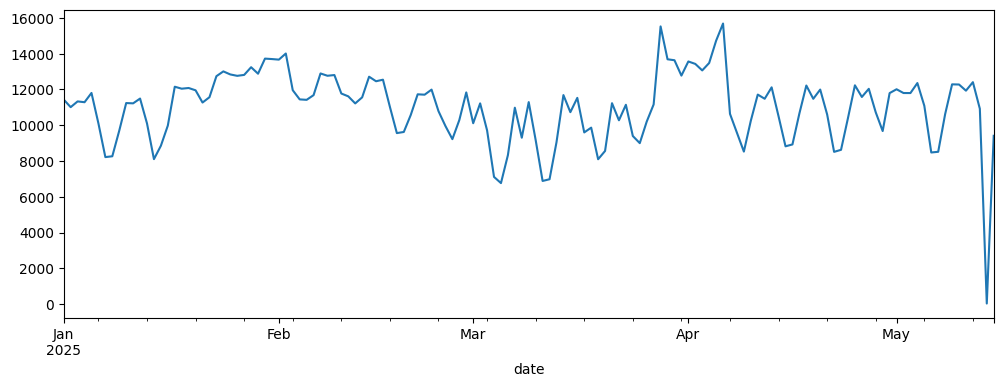

In [5]:
import matplotlib.pyplot as plt

df_daily['ridership'].plot(figsize=(12,4))
plt.show()

In [6]:
import holidays

my_holidays = holidays.MY(years=[2023,2024,2025])
df_daily['is_holiday'] = df_daily.index.to_series().apply(lambda x:x in my_holidays)

In [7]:
df_daily[df_daily['is_holiday']==True]

,ridership,is_holiday
date,,
2025-01-29,12880,True
2025-01-30,13724,True
2025-03-31,12774,True
2025-04-01,13564,True
2025-05-01,12010,True
2025-05-12,12407,True


In [8]:
df_daily['dayofweek'] = df_daily.index.dayofweek # 0 = Monday, 6 = Sunday

ADF

In [9]:
# check for linearity
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_daily['ridership'])
print("Augmented Dickey-Fuller (ADF): ", result[0])
print("p-value: ", result[1])

# The ADF test helps determine if a time series is stationary or non-stationary. Stationarity is a key assumption for many time series models and forecasting techniques.
# If a time series is non-stationary, its statistical properties (like mean and variance) change over time, making it unsuitable for certain models. 

Augmented Dickey-Fuller (ADF):  -3.0917297298986015
p-value:  0.02717131028119046


| Term                            | Meaning                                                                                    |
| ------------------------------- | ------------------------------------------------------------------------------------------ |
| **ADF Statistic**               | The test statistic. The more negative, the stronger the evidence against non-stationarity. |
| **p-value**                     | If **< 0.05**, we reject the null hypothesis. That means the data is **stationary**.       |
| **Null Hypothesis (H₀)**        | The series **has a unit root** → i.e., it is **non-stationary**.                           |
| **Alternative Hypothesis (H₁)** | The series is **stationary**.                                                              |


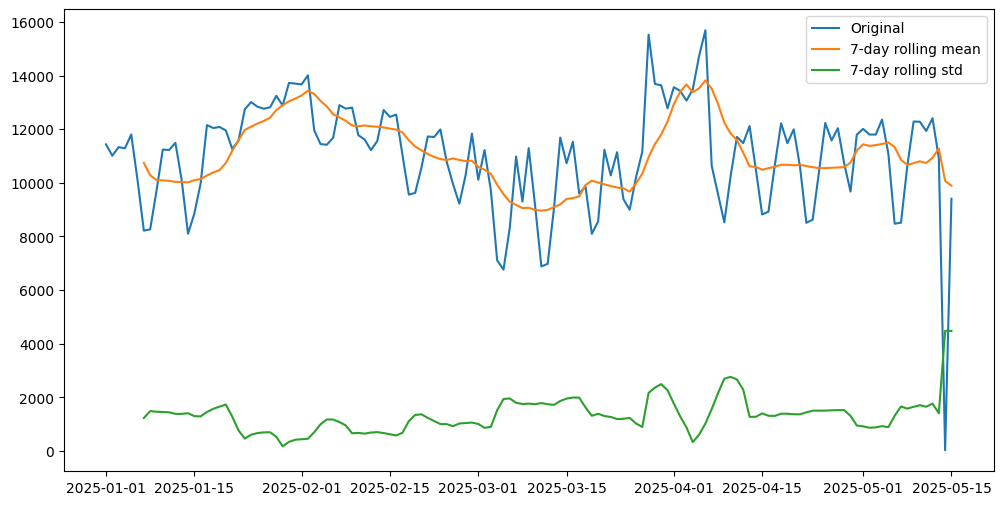

In [10]:
#plot moving average

df_daily['rolling_mean'] = df_daily['ridership'].rolling(window=7).mean()
df_daily['rolling_std'] = df_daily['ridership'].rolling(window=7).std()

plt.figure(figsize=(12,6))
plt.plot(df_daily['ridership'],label='Original')
plt.plot(df_daily['rolling_mean'], label='7-day rolling mean')
plt.plot(df_daily['rolling_std'],label='7-day rolling std')
plt.legend()
plt.show()

Original Line (Blue or solid)
→ This is the actual ridership on Jan 15.
For example: if the y-axis shows 6,000, then 6,000 people used the system that day.

Rolling Mean Line (e.g., orange or dashed)
→ This shows the average ridership over the previous 7 days leading up to Jan 15 (i.e., Jan 9 to Jan 15).
If the orange line is at 5,800, it means on average, about 5,800 people used the LRT each day in the last week.

Rolling Std Dev Line (e.g., green or dotted)
→ This line tells you how much variation there was in daily ridership in that same 7-day window.
If it’s low, ridership was steady. If it’s high, ridership was bouncing up and down.

Summary
- Our data is non-stationary it has trends and seasonality, ADF null hypothesis is accepted.
- Our earlier line graph with rolling mean and std dev already hinted this (they weren’t stable).
- Our seasonal spikes (likely due to holidays, weekdays, etc.) reinforce this.

This aligns with real-world transport data, behavior is usually not constant over time.

Removing holiday date

In [11]:
# lets try to remove holidays
df_daily_non_holiday = df_daily[df_daily['is_holiday'] == False]

result = adfuller(df_daily_non_holiday['ridership'])
print("Augmented Dickey-Fuller (ADF): ", result[0])
print("p-value: ", result[1])

Augmented Dickey-Fuller (ADF):  -3.0425593433524245
p-value:  0.031106545420458428


Differencing

In [49]:
# lets try to remove holidays and differencing
df_daily_non_holiday = df_daily[df_daily['is_holiday'] == False]
df_daily_non_holiday['diff'] = df_daily_non_holiday['ridership'].diff().dropna()


result = adfuller(df_daily_non_holiday['diff'].dropna())
print("Augmented Dickey-Fuller (ADF): ", result[0])
print("p-value: ", result[1])

Augmented Dickey-Fuller (ADF):  -4.467531704329729
p-value:  0.00022498045065372002


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13856\918205549.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_non_holiday['diff'] = df_daily_non_holiday['ridership'].diff().dropna()


In [50]:
# lets try to differencing
#df_daily_non_holiday = df_daily[df_daily['is_holiday'] == False]
df_daily['diff'] = df_daily['ridership'].diff().dropna()


result = adfuller(df_daily['diff'].dropna())
print("Augmented Dickey-Fuller (ADF): ", result[0])
print("p-value: ", result[1])

Augmented Dickey-Fuller (ADF):  -3.311785140684224
p-value:  0.014359827210250857


Model identification
When we build an ARIMA model, we have to consider the p, d, and q terms that go into our ARIMA model. 

- The first parameter, p, is the number of lagged observations. By considering p, we effectively determine how far back in time we go when trying to predict the current observation. We do this by looking at the autocorrelations of our time series, which are the correlations in our series at previous time lags. 
- The second parameter, d, refers to the order of differencing, which we talked about. Again, differencing simply means finding the differences between consecutive timesteps. It is a way to make our data stationary, which means removing the trends and any changes in variance over time. d indicates differencing at which order you get a process stationary.
- The third parameter q refers to the order of the moving average (MA) part of the model. It represents the number of lagged forecast errors included in the model. Unlike a simple moving average, which smooths data, the moving average in ARIMA captures the relationship between an observation and the residual errors from a moving average model applied to lagged observations.

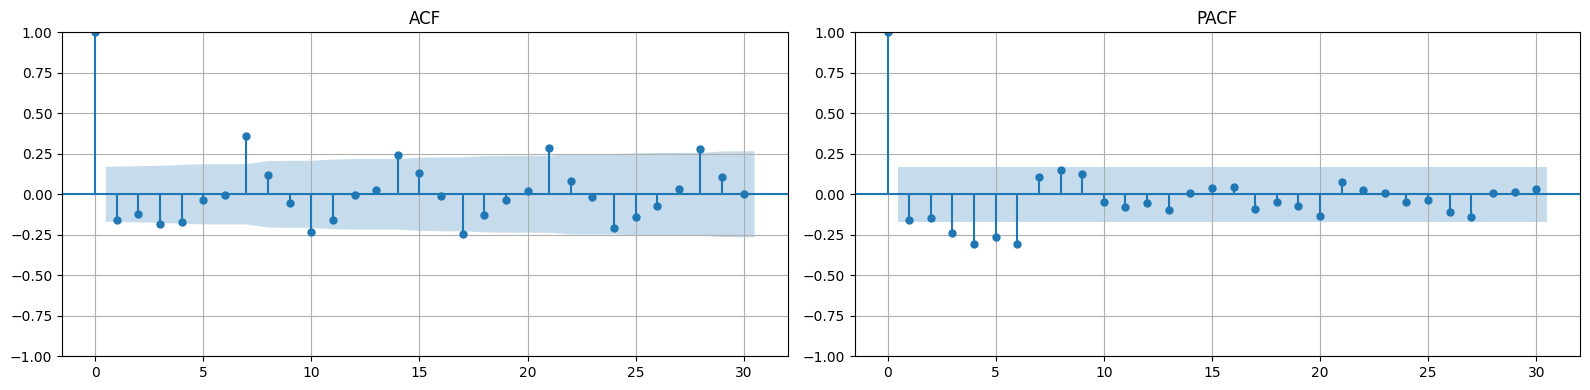

In [47]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for the differenced series
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

plot_acf(df_daily['diff'].dropna(), lags=30, ax=axes[0])
axes[0].set_title("ACF")
axes[0].grid(True)


plot_pacf(df_daily['diff'].dropna(), lags=30, ax=axes[1])
axes[1].set_title("PACF")
axes[1].grid(True)

plt.tight_layout()
plt.show()

- p (looks at past values): (Interprest PACF) How far we should go back to make prediction on current observation: PACF cuts off at none
- d: At which order to get a process stationary, d = 1
- q (looks at past forecast errors): (Interpret ACF), weekly seasonality, suggested to use SARIMA model instead

PACF remove the indirect correlations which ACF shows stacking correlations (due to compounding)

How to Read the ACF Plot
X-axis (lags):

Represents how many time steps (lags) back you're comparing your current value to.

Example: Lag 7 means you're comparing today's ridership to the value 7 days ago.

Y-axis (autocorrelation value):

Shows the correlation coefficient between the time series and its lagged version.

Values range between -1 and 1:

1.0 → Perfect positive correlation.

0.75 → Strong positive correlation.

0.0 → No correlation.

-0.75 → Strong negative correlation.

Summary: in PACF, highest spike at 7, 8, 9 lags with 8 being the slightly highest, lets redo to include 2 months lag

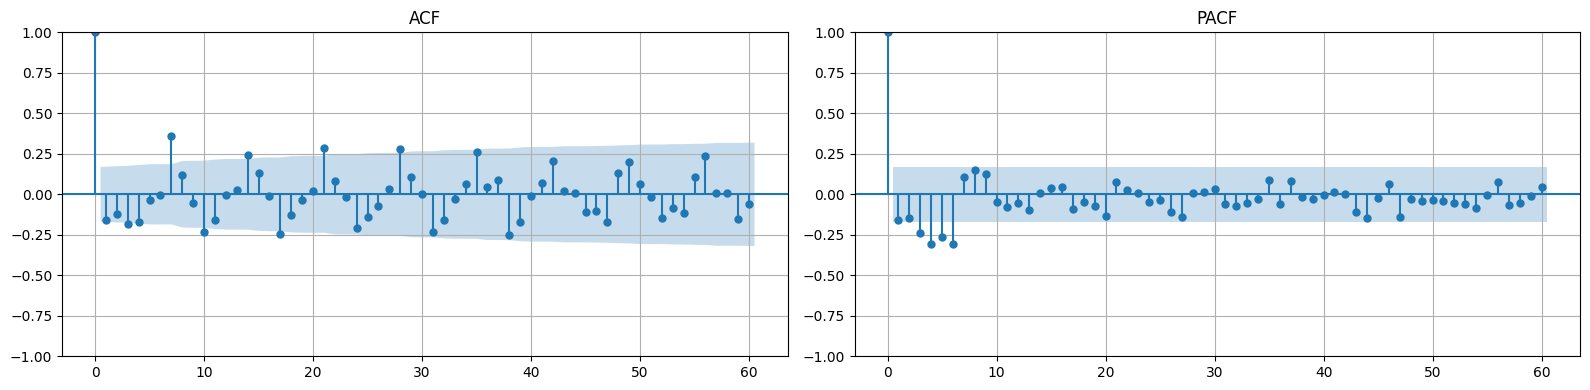

In [51]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for the differenced series
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

plot_acf(df_daily['diff'].dropna(), lags=60, ax=axes[0])
axes[0].set_title("ACF")
axes[0].grid(True)


plot_pacf(df_daily['diff'].dropna(), lags=60, ax=axes[1])
axes[1].set_title("PACF")
axes[1].grid(True)

plt.tight_layout()
plt.show()

Yup definitely lags at 7,8,9 is not seasonal, these are short-term correlations

Let’s say your seasonality period is s = 7 (weekly cycle). Then, you check:

1. PACF → Seasonal AR (P)
Look at lags = 7, 14, 21, ...

- If there's a significant spike at lag 7 in PACF and drops after, that suggests:
- P = 1
- Because the partial autocorrelation is strong only at the first seasonal lag

2. ACF → Seasonal MA (Q)
Look at lags = 7, 14, 21, ...

- If there's a significant spike at lag 7 in ACF and then decays, that suggests:
- Q = 1
- Because the autocorrelation remains high at that periodic lag

🧠 Your case:
- ACF: Strong spike at lag 7, 14, 21 → implies Q = 1
- PACF: Visible spike at lag 7 only, weak after → implies P = 1

Even though spikes appear at 14, 21 too, they're weaker → no need for P=2 or Q=2 unless the model performs poorly.

So our choosen metrics:

- p: 0
- q: 0
- d: 1
- P: 1
- Q: 1
- D: 1
- s: 7 (weekly seasonal)

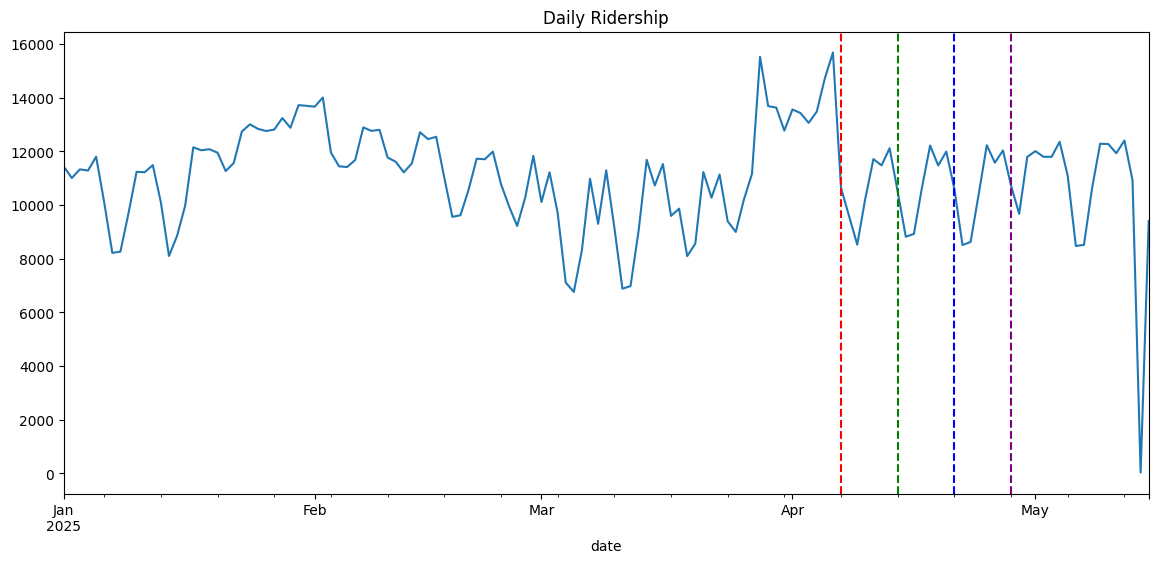

In [86]:
#lets plot
df_daily['ridership'].plot(figsize=(14,6), title="Daily Ridership")
plt.axvline('2025-4-7', color='red',linestyle='--')
plt.axvline('2025-4-14', color='green',linestyle='--')
plt.axvline('2025-4-21', color='blue',linestyle='--')
plt.axvline('2025-4-28', color='purple',linestyle='--')

# Hold up there is data error

In [62]:
df_daily.sort_values(by='date',ascending=False) #whats's happening on 14th May?

,ridership,is_holiday,dayofweek,rolling_mean,rolling_std,rolling_diff_19,diff
date,,,,,,,
2025-05-15,9408,False,3,9894.000000,4480.453586,-2172.0,9378.0
2025-05-14,30,False,2,10067.000000,4481.939907,-12201.0,-10890.0
2025-05-13,10920,False,1,11279.000000,1409.169022,518.0,-1487.0
2025-05-12,12407,True,0,10929.714286,1769.843469,3783.0,475.0
2025-05-11,11932,False,6,10741.000000,1652.615906,3422.0,-344.0
...,...,...,...,...,...,...,...
2025-01-05,11804,False,6,NaN,NaN,NaN,518.0
2025-01-04,11286,False,5,NaN,NaN,NaN,-45.0
2025-01-03,11331,False,4,NaN,NaN,NaN,321.0


In [73]:
df_daily['ridership'].sum()

np.int64(1487593)

In [72]:
df_daily.mean()

ridership          11019.207407
is_holiday             0.044444
dayofweek              2.992593
rolling_mean       11077.482835
rolling_std         1345.168449
rolling_diff_19       -2.224138
diff                 -15.119403
dtype: float64

In [71]:
print(1487593/135)

11019.207407407408


In [63]:
df_daily.sort_values(by='ridership') #Might be data error as it is too far from the second lowest daily total ridership

,ridership,is_holiday,dayofweek,rolling_mean,rolling_std,rolling_diff_19,diff
date,,,,,,,
2025-05-14,30,False,2,10067.000000,4481.939907,-12201.0,-10890.0
2025-03-05,6763,False,2,9577.000000,1941.235517,-5950.0,-347.0
2025-03-11,6883,False,1,8959.571429,1790.010974,-3688.0,-2288.0
2025-03-12,6979,False,2,8990.428571,1747.183816,-4749.0,96.0
2025-03-04,7110,False,1,9928.142857,1525.090317,-4448.0,-2602.0
...,...,...,...,...,...,...,...
2025-01-30,13724,True,3,13038.428571,342.875029,2501.0,844.0
2025-02-02,14009,False,6,13433.571429,459.760031,5906.0,342.0
2025-04-05,14724,False,5,13523.857143,610.837247,5127.0,1244.0


In [82]:
# #plot moving average

# df_daily_non_holiday['rolling_mean'] = df_daily_non_holiday['diff'].dropna().rolling(window=7).mean()
# df_daily_non_holiday['rolling_std'] = df_daily_non_holiday['diff'].dropna().rolling(window=7).std()

# plt.figure(figsize=(12,6))
# plt.plot(df_daily_non_holiday['diff'].dropna(),label='Original')
# plt.plot(df_daily_non_holiday['rolling_mean'], label='7-day rolling mean')
# plt.plot(df_daily_non_holiday['rolling_std'],label='7-day rolling std')
# plt.legend()
# plt.show()

Lets impute the value for 14th May

In [76]:
import numpy as np
df_daily_smoothed = df_daily.copy()
df_daily_smoothed['ridership'] = df_daily_smoothed['ridership'].replace(30,np.nan)

- 7-day rolling average: This typically means the mean of the previous 7 days (not centered, unless you explicitly choose centered)
- This is good for short-term smoothing and seasonality handling.

In [79]:
df_daily_smoothed['ridership'] = df_daily_smoothed['ridership'].fillna(df_daily_smoothed['ridership'].rolling(window=7, min_periods=1).mean())


In [81]:
df_daily_smoothed.sort_values(by='date', ascending=False)

,ridership,is_holiday,dayofweek,rolling_mean,rolling_std,rolling_diff_19,diff
date,,,,,,,
2025-05-15,9408.000000,False,3,9894.000000,4480.453586,-2172.0,9378.0
2025-05-14,11739.833333,False,2,10067.000000,4481.939907,-12201.0,-10890.0
2025-05-13,10920.000000,False,1,11279.000000,1409.169022,518.0,-1487.0
2025-05-12,12407.000000,True,0,10929.714286,1769.843469,3783.0,475.0
2025-05-11,11932.000000,False,6,10741.000000,1652.615906,3422.0,-344.0
...,...,...,...,...,...,...,...
2025-01-05,11804.000000,False,6,NaN,NaN,NaN,518.0
2025-01-04,11286.000000,False,5,NaN,NaN,NaN,-45.0
2025-01-03,11331.000000,False,4,NaN,NaN,NaN,321.0


# Let's fit in the model!

In [83]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [116]:
model = SARIMAX(df_daily_smoothed['ridership'],
                order=(0,1,0),
                seasonal_order=(1,1,1,7),
                enforce_invertibility=False,
                enforce_stationarity=False)

results = model.fit()

print("AIC: ", results.aic)
print("BIC: ", results.bic)

c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


AIC:  1996.3312865285238
BIC:  2004.6686570078584


In [115]:
model = SARIMAX(df_daily['ridership'],
                order=(0,1,0),
                seasonal_order=(1,1,1,7),
                enforce_invertibility=False,
                enforce_stationarity=False)

results2 = model.fit()

print("AIC: ", results2.aic)
print("BIC: ", results2.bic)

AIC:  2103.0953418328313
BIC:  2111.4327123121657


c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [114]:
model = SARIMAX(df_daily_smoothed['ridership'],
                order=(1,1,1),
                seasonal_order=(1,1,1,7),
                enforce_invertibility=False,
                enforce_stationarity=False)

results3 = model.fit()

print("AIC: ", results3.aic)
print("BIC: ", results3.bic)

c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


AIC:  1977.3011946622535
BIC:  1991.154617784582


In [113]:
model = SARIMAX(df_daily_smoothed['ridership'],
                order=(0,1,1),
                seasonal_order=(1,1,1,7),
                enforce_invertibility=False,
                enforce_stationarity=False)

results4 = model.fit()

print("AIC: ", results4.aic)
print("BIC: ", results4.bic)


c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


AIC:  1976.9751760325141
BIC:  1988.0579145303768


In [112]:
model = SARIMAX(df_daily_smoothed['ridership'],
                order=(1,1,0),
                seasonal_order=(1,1,1,7),
                enforce_invertibility=False,
                enforce_stationarity=False)

results5 = model.fit()

print("AIC: ", results5.aic)
print("BIC: ", results5.bic)

c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


AIC:  1995.5783710549351
BIC:  2006.6948650273812


In [110]:
model = SARIMAX(df_daily_smoothed['ridership'],
                order=(0,1,1),
                seasonal_order=(2,1,2,7),
                enforce_invertibility=False,
                enforce_stationarity=False)

results6 = model.fit()

print("AIC: ", results6.aic)
print("BIC: ", results6.bic)

c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


AIC:  1859.9282044307174
BIC:  1876.1853856385915


In [109]:
model = SARIMAX(df_daily_smoothed['ridership'],
                order=(0,1,1),
                seasonal_order=(2,1,1,7),
                enforce_invertibility=False,
                enforce_stationarity=False)

results7 = model.fit()

print("AIC: ", results7.aic)
print("BIC: ", results7.bic)

c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


AIC:  1893.538422496687
BIC:  1907.1753615902487


In [111]:
model = SARIMAX(df_daily_smoothed['ridership'],
                order=(0,1,1),
                seasonal_order=(1,1,2,7),
                enforce_invertibility=False,
                enforce_stationarity=False)

results8 = model.fit()

print("AIC: ", results8.aic)
print("BIC: ", results8.bic)

c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


AIC:  1859.9169868452589
BIC:  1873.4646378518205


Results8 is the lowest: 
- order=(0,1,1),
- seasonal_order=(1,1,2,7)

| Metric  | Value   | What It Means                                                                              |
| ------- | ------- | ------------------------------------------------------------------------------------------ |
| **AIC** | 1859.9169868452589 | Akaike Information Criterion — penalizes complexity but favors good fit. Lower is better.  |
| **BIC** | 1873.4646378518205 | Bayesian Information Criterion — more strict against complexity than AIC. Lower is better. |


In [123]:
model_fit = results8

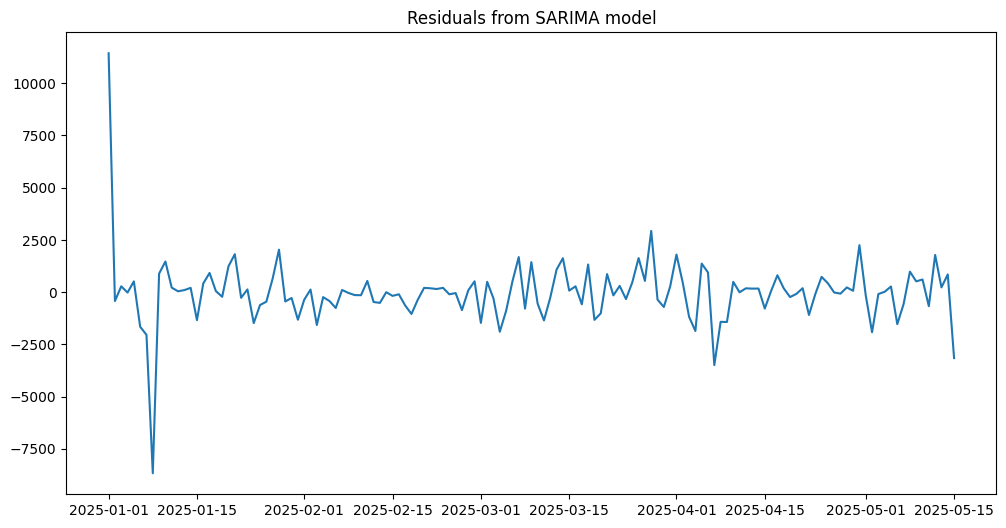

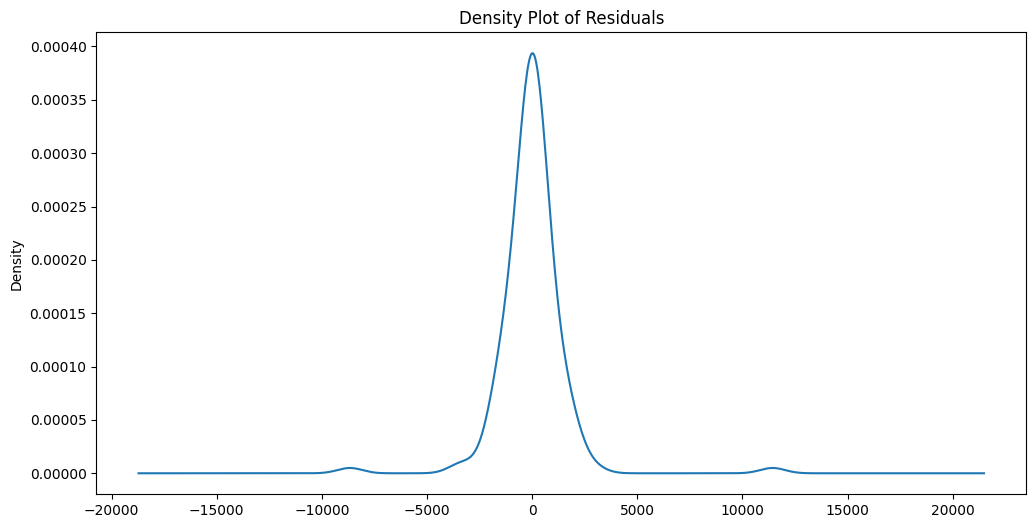

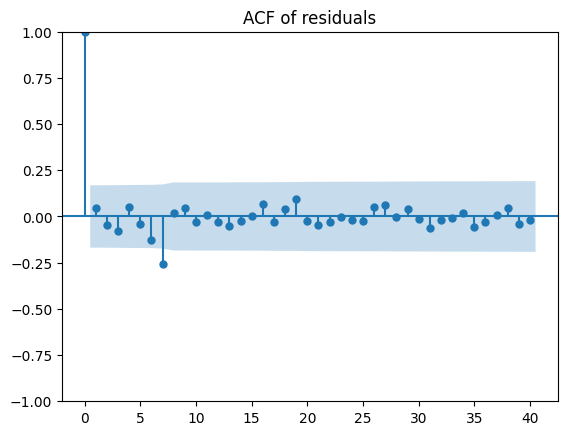

      lb_stat  lb_pvalue
10  14.156283   0.165982
20  17.400847   0.626813


In [157]:
import statsmodels.api as sm
#1. plot residuals
residuals = model_fit.resid
plt.figure(figsize=(12,6))
plt.plot(residuals)
plt.title('Residuals from SARIMA model')
plt.show()

#2. plot residuals density
plt.figure(figsize=(12,6))
residuals.plot(kind='kde')
plt.title("Density Plot of Residuals")
plt.show()

#3. ACF plot of residuals
sm.graphics.tsa.plot_acf(residuals,lags=40)
plt.title('ACF of residuals')
plt.show()

#4. Ljung-Box test to check for autocorrelation in residuals
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(residuals, lags=[10,20], return_df=True)
print(lb_test)

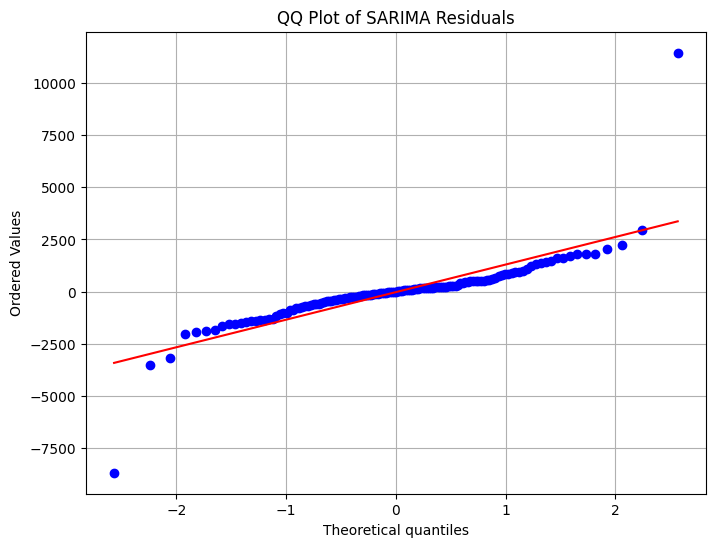

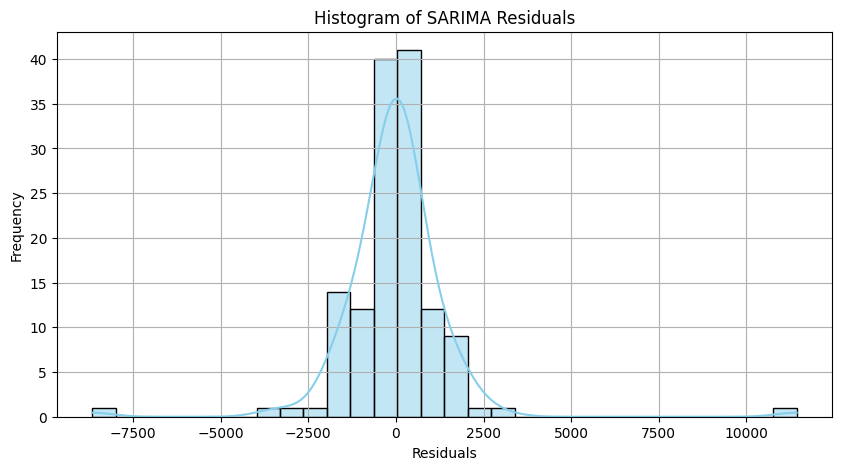

In [128]:
import scipy.stats as stats
import seaborn as sns

residuals = model_fit.resid

#QQ plot
plt.figure(figsize=(8,6))
stats.probplot(residuals,dist="norm", plot=plt)
plt.title("QQ Plot of SARIMA Residuals")
plt.grid()
plt.show()

#Histogram
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, bins=30, color='skyblue')
plt.title("Histogram of SARIMA Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid()
plt.show()

How to interpret the QQ plot:
- If the points lie along the 45° line, the residuals are approximately normally distributed.
- Systematic deviations (like an S-curve or heavy tails) indicate the residuals deviate from normality:
- Heavy tails → outliers
- Curved shape → skewness
- Clustering → misspecification or non-normality

How to interpret Histogram:
- A symmetric, bell-shaped curve suggests residuals are roughly normally distributed.
- If it’s skewed, has multiple peaks, or long tails, that may indicate:
- Non-normality
- Model misspecification
- Outliers
- Unaccounted seasonality or trend

In [144]:
model_fit = results8

In [174]:
print(model_fit.summary())

                                       SARIMAX Results                                        
Dep. Variable:                              ridership   No. Observations:                  135
Model:             SARIMAX(0, 1, 1)x(1, 1, [1, 2], 7)   Log Likelihood                -924.958
Date:                                Fri, 16 May 2025   AIC                           1859.917
Time:                                        19:29:14   BIC                           1873.465
Sample:                                    01-01-2025   HQIC                          1865.413
                                         - 05-15-2025                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3140      0.094     -3.355      0.001      -0.497      -0.131
ar.

Interpretation of Ljung-Box "Prob(Q)" in model diagnostics:
- If p-value > 0.05 → Fail to reject the null hypothesis
- This means no significant autocorrelation in residuals — which is good. Your model has likely captured most of the structure in the data, and the residuals resemble white noise.


- If p-value ≤ 0.05 → Reject the null hypothesis
- This suggests autocorrelation is still present in the residuals — a sign that your model may be misspecified or underfitting.

In [203]:
model = SARIMAX(df_daily_smoothed['ridership'],
                order=(0,1,1),
                seasonal_order=(0,1,1,7),  # Removed ar.S.L7 and ma.S.L14
                enforce_invertibility=False,
                enforce_stationarity=False)

results9 = model.fit()

print("AIC: ", results9.aic)
print("BIC: ", results9.bic)

c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\LENOVO\2025Trial\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


AIC:  1975.5636793608817
BIC:  1983.8757332342786


In [204]:
model_fit1 = results9
print(model_fit1.summary())

                                     SARIMAX Results                                     
Dep. Variable:                         ridership   No. Observations:                  135
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 7)   Log Likelihood                -984.782
Date:                           Fri, 16 May 2025   AIC                           1975.564
Time:                                   19:41:15   BIC                           1983.876
Sample:                               01-01-2025   HQIC                          1978.939
                                    - 05-15-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3038      0.083     -3.653      0.000      -0.467      -0.141
ma.S.L7       -0.8541      0.050    -17.217

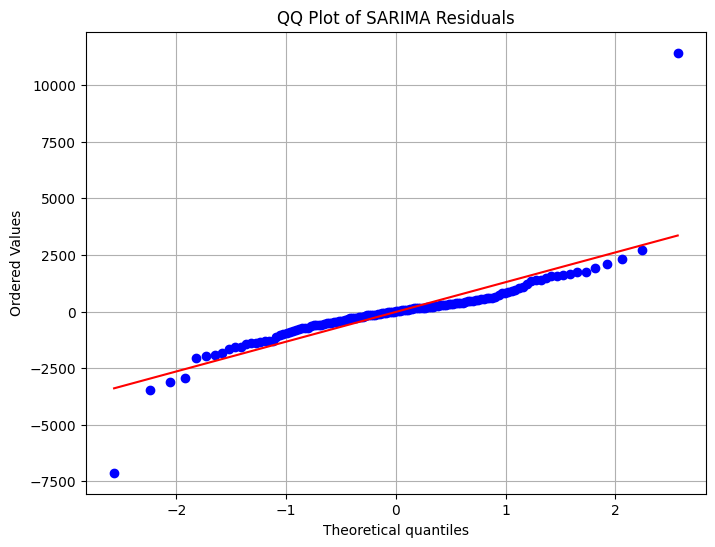

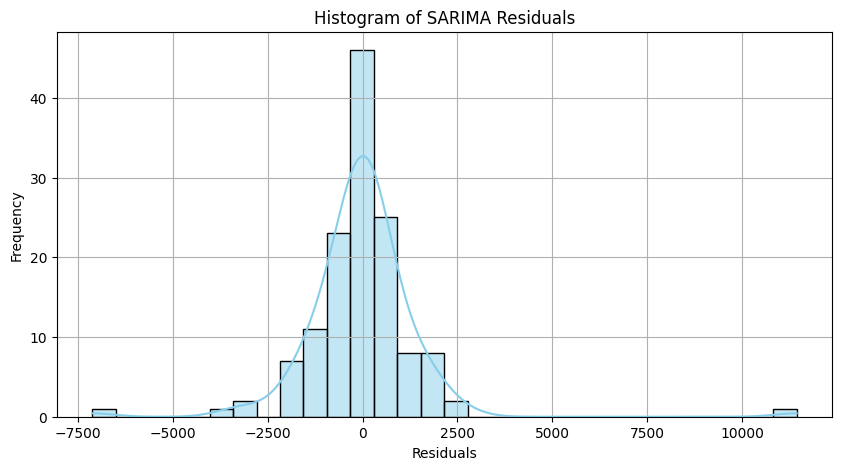

In [165]:
import scipy.stats as stats
import seaborn as sns

residuals = model_fit1.resid

#QQ plot
plt.figure(figsize=(8,6))
stats.probplot(residuals,dist="norm", plot=plt)
plt.title("QQ Plot of SARIMA Residuals")
plt.grid()
plt.show()

#Histogram
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, bins=30, color='skyblue')
plt.title("Histogram of SARIMA Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid()
plt.show()